# Coal to Gas Switching in US power generation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import collections
# rdms_gas.py and C2GTest.py are included with this notebook on Github
import rdms_gas as rdms
import C2GTest as C2GTest

## Import price RICs

In [2]:
ngi_RIC = pd.read_csv('NGI_PriceRegions.csv',index_col=0)

## Assign prices to regions and run

In [3]:
ric = dict()
names = dict()
ric['MISO'] = list(ngi_RIC.index[ngi_RIC['REGION'].str.match('Mid-Continent|MidWest|LA')])
names['MISO'] = list(ngi_RIC.NAME[ngi_RIC['REGION'].str.match('Mid-Continent|MidWest|LA')])
ric['ERCO'] = list(ngi_RIC.index[ngi_RIC['REGION'].str.match('TX|LA')])
names['ERCO'] = list(ngi_RIC.NAME[ngi_RIC['REGION'].str.match('TX|LA')])
ric['SWPP'] = list(ngi_RIC.index[ngi_RIC['REGION'].str.match('TX|LA|Mid-Continent')])
names['SWPP'] = list(ngi_RIC.NAME[ngi_RIC['REGION'].str.match('TX|LA|Mid-Continent')])
ric['PJM'] = list(ngi_RIC.index[ngi_RIC['REGION'].str.match('Appalachia|MidWest')])
names['PJM'] = list(ngi_RIC.NAME[ngi_RIC['REGION'].str.match('Appalachia|MidWest')])
singleprice = dict()
singleprice_NGc1 = dict()
doubleprice = dict()
doubleprice_NGc1 = dict()
regions = ['MISO','SWPP','ERCO','PJM']

# exclude the Texas Blackout period
exclusion_dates = pd.date_range(start='02/10/2021', end='03/01/2021', freq='D')

for i in regions:
    singleprice[i],isodata,price_df = C2GTest.RegionalC2GTest(i,['CQPR8C1','NGc1'],  ric[i],1,names[i],         0,      0,       0,exclusion_dates)
    doubleprice[i],_,_              = C2GTest.RegionalC2GTest(i,['CQPR8C1','NGc1'],  ric[i],2,names[i],         0,isodata,price_df,exclusion_dates)
    singleprice_NGc1[i],_,_         = C2GTest.RegionalC2GTest(i,['CQPR8C1'],['NGc1']+ric[i],1,['NGc1']+names[i],0,isodata,price_df,exclusion_dates)
    doubleprice_NGc1[i],_,_         = C2GTest.RegionalC2GTest(i,['CQPR8C1'],['NGc1']+ric[i],2,['NGc1']+names[i],0,isodata,price_df,exclusion_dates)
    

/Users/alex.putkov/opt/miniconda3/envs/refinitiv/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## Prepare output

In [4]:
output = dict()

for x in regions:
    sublist = doubleprice_NGc1[x]
    sublist = sublist[sublist['Rsq']>sublist['Rsq'].quantile(q=0.9)]
    p = [[i,j] for i, j in sublist.index]
    sublist2 = list(itertools.chain(*p))
    df = pd.DataFrame.from_dict(collections.Counter(sublist2), orient='index', columns = ['Freq'])
    output[x] = df.sort_values(by = ['Freq'])

## Plot the pie charts on the map of Regional Transmission Organizations
The pie charts illustrate which plants have the most influence over the ratio of coal to gas on the power grid

In [5]:
from math import pi
import geopandas as gpd
import bokeh
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.io import output_notebook, show
output_notebook(hide_banner=True)

gdf = gpd.read_file('ISOMap')
geosource = bokeh.models.GeoJSONDataSource(geojson = gdf.to_json())
p = figure(title = 'Price Hubs that Influence Coal to Gas Switching', 
           plot_height = 600 ,
           plot_width = 950, 
           toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.axis.visible = False
p.title.align = "center"
p.title.text_color = "#001EFF"
p.title.text_font_size = "25px"
# Add patch renderer to figure.
chart_regions = p.patches('xs','ys', source = geosource,
                          fill_color = 'color',
                          line_color = 'gray', 
                          line_width = 0.25, 
                          fill_alpha = 'fill_alpha')
# Add pie charts
pie_coordinates = {'MISO': [45, -91], 'SWPP': [38, -99], 'ERCO': [30, -99], 'PJM': [39, -79]}
pie_colors = ['#800000','#000075','#F58231','#FFE119','#911EB4','#000000',
             '#E6194B','#BFEF45','#DCBEFF','#A9A9A9','#4363D8','#9A6324']
pie_chart_data = dict()
for x in regions:
    pie_chart_data[x] = output[x].tail(3)['Freq']
pie_chart_data = pd.DataFrame(pie_chart_data)
pie_chart_data.fillna(0, inplace = True)
pie_chart_data['Color'] = pie_colors[:len(pie_chart_data.index)]

for w in pie_coordinates.keys():
    pie_chart_data[f'Angle_{w}'] = pie_chart_data[w]/pie_chart_data[w].sum() * 2*pi

renderlist = []
pie_chart_data_source = bokeh.models.sources.ColumnDataSource(pie_chart_data)

for w in pie_coordinates.keys():
    lat, lon = (pie_coordinates[w][0], pie_coordinates[w][1])
    r = p.wedge(x=lon, y=lat, radius=1.5, alpha=1,
                start_angle=cumsum(f'Angle_{w}', include_zero=True),
                end_angle=cumsum(f'Angle_{w}'),
                line_color='white', fill_color='Color',
                source=pie_chart_data_source)
    renderlist.append(r)
    p.add_tools(bokeh.models.HoverTool(tooltips = [('Price Hub', '@index'),('Region', w)], renderers=[r]))

legend = bokeh.models.Legend(items=[bokeh.models.LegendItem(label=dict(field='index'),renderers=renderlist)],
                             location='bottom_right')
p.add_layout(legend)

show(p)

## Regional Analysis

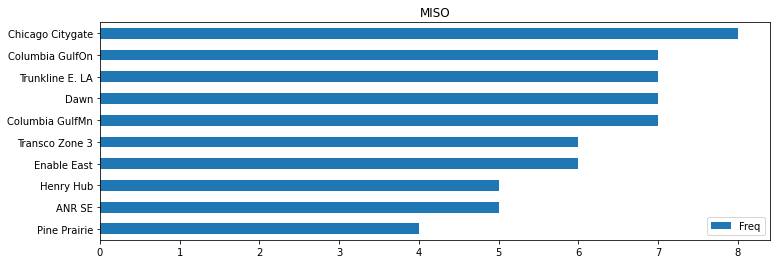

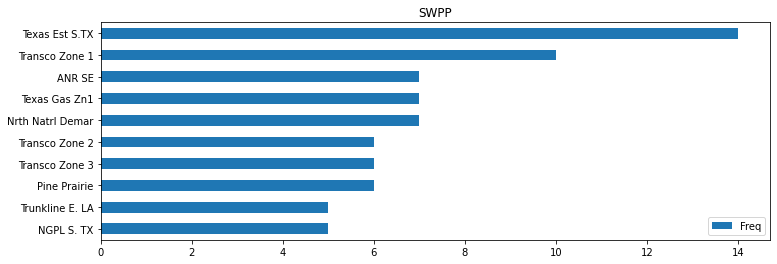

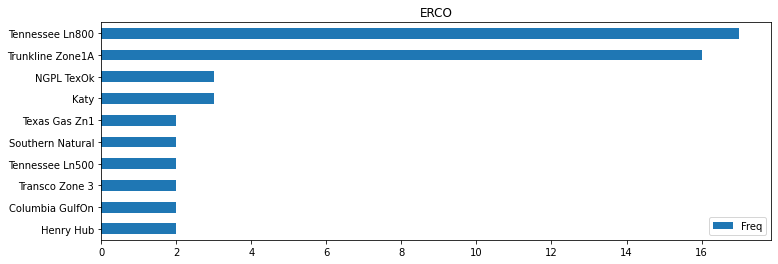

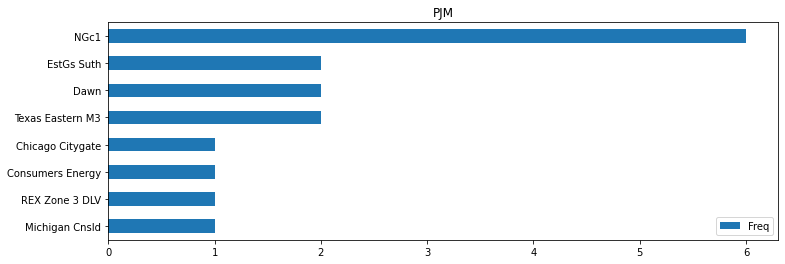

In [6]:
for x in regions:
    output[x].tail(10).plot.barh(figsize=(12,4),title=x)